#  Churn Prediction and Analysis

The purpose of this notebook is to use classification models in order to predict if a customer is churned.  Those models will then be used to examine which features most impact churn and what business insights can be derived from that. 

1. Define Churn

2. Examine general statistics for churn/no churn.

3. Prepare data for modeling

4. Examine the results of a dummy classifier.

5. Compare results from LinearSVC, K-NN, SVC, and Random Forest Classifiers.

6. Examine SHAP feature weights in order to uncover insights from models.

In this instance I would generally start ith a random forest model since that tends to be my go-to.  However in order to avoid this bias we're going to rely on this chart provided by Sci-Kit learn for choosing a model and ensure that I'm actually trying models I would typically pass over. 

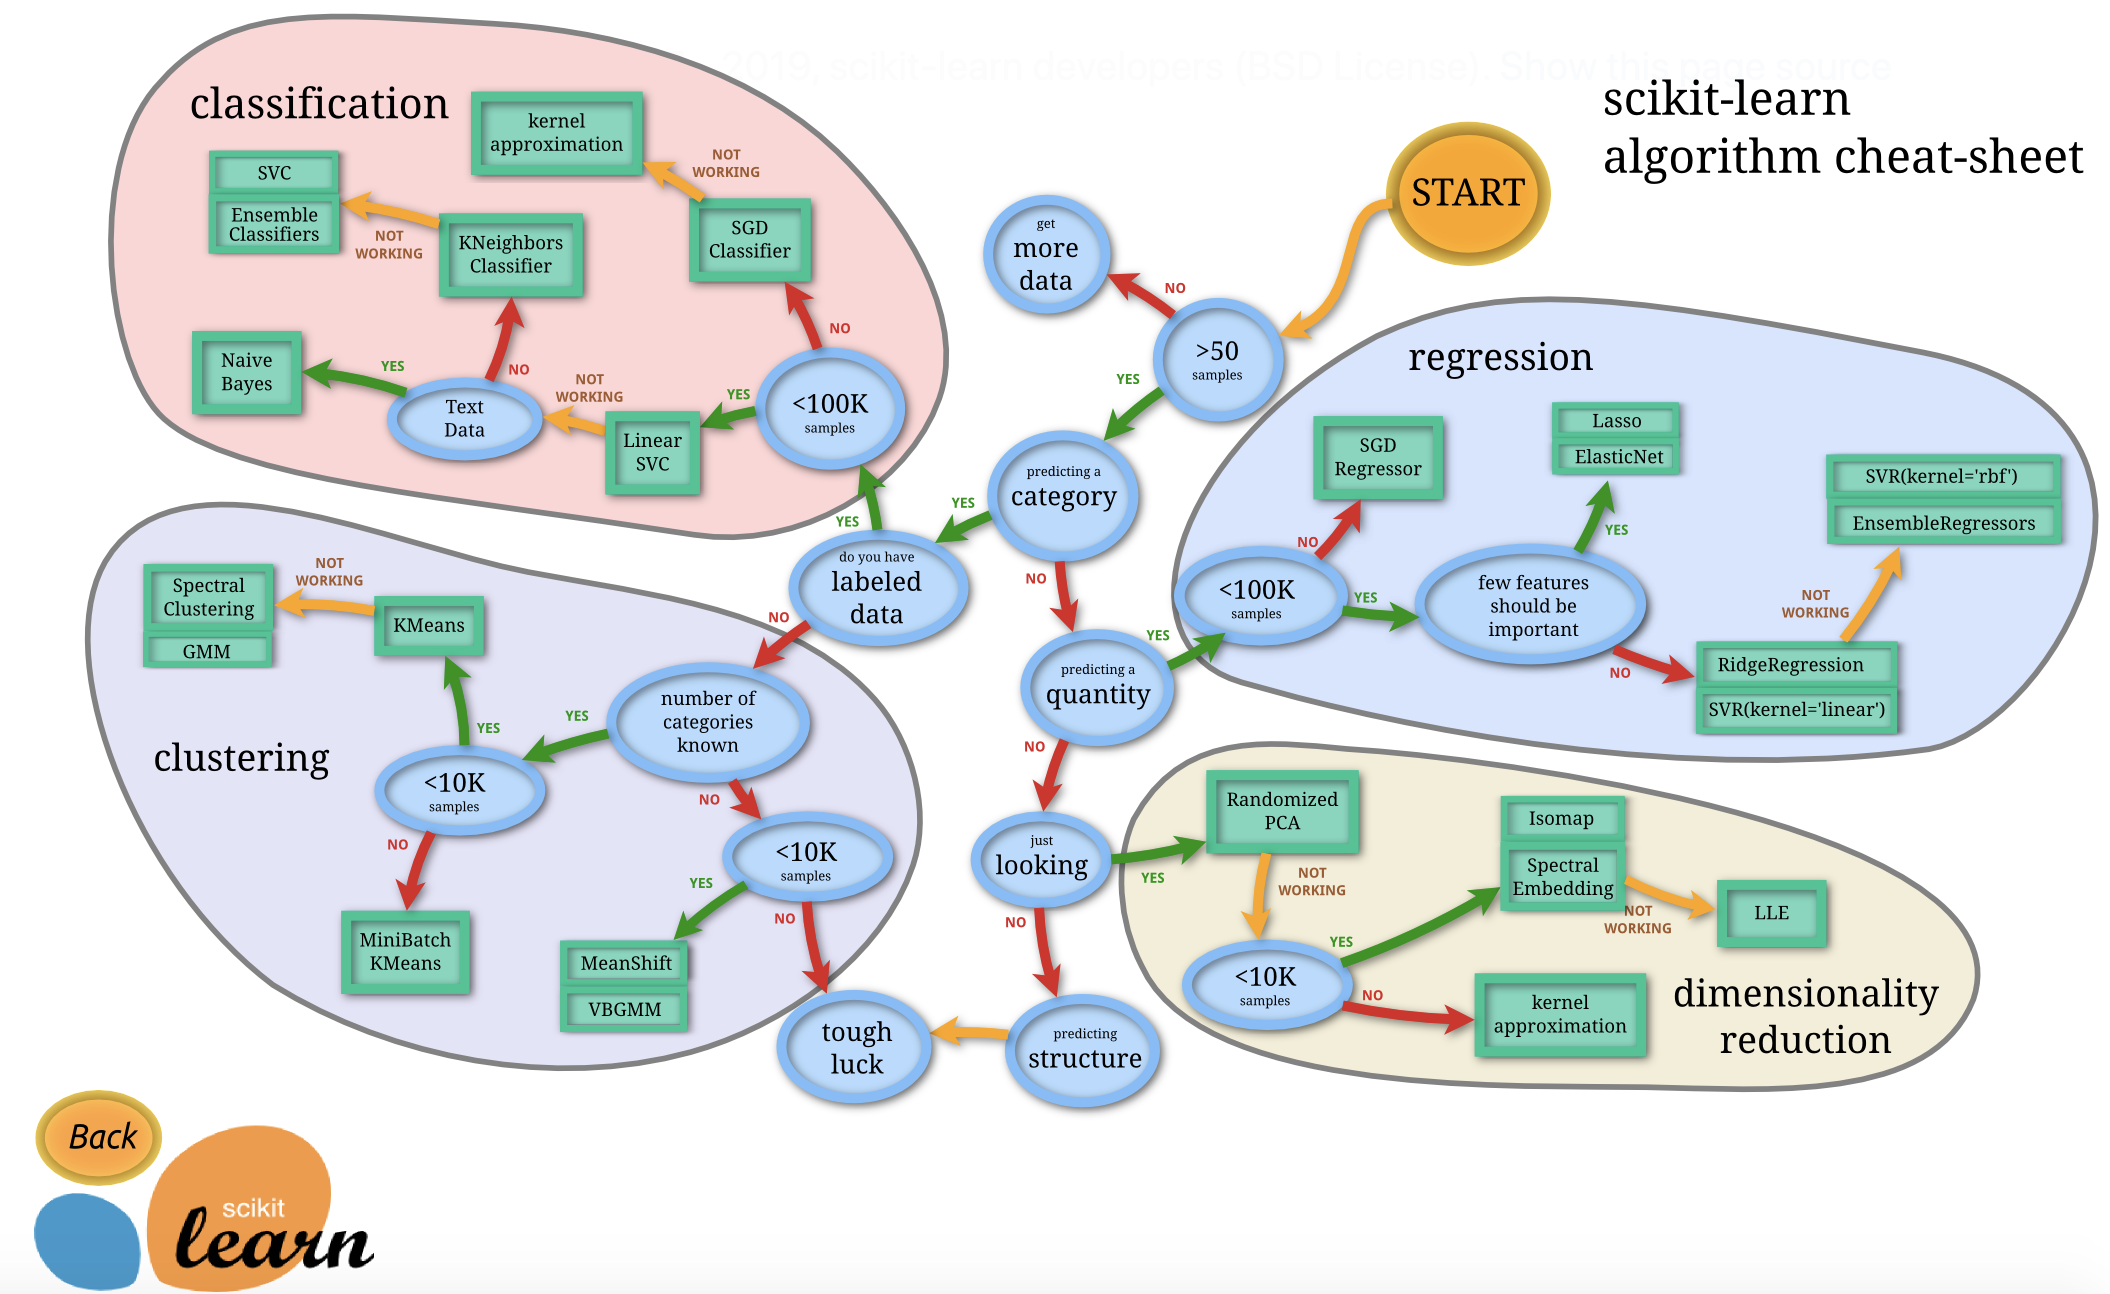

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV 
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
#setup Pandas
pd.set_option('display.max_columns', None)

In [2]:
# Load cleaned data
df = pd.read_parquet('../Data/Cleaned_Customer_Data')
# Load correlation thresholds
corr = pd.read_csv('../Data/Correlation_Thresholds', index_col = 'Unnamed: 0')

In [3]:
df.head()

,Age,Marital_status,Income,Homeowner_status,Household_comp,Household_size,Kids,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,CouponRedeemed_Count,CouponSent_Count,Percent_CouponsRedeemed,TypeA,TypeB,TypeC,PercentTypeA,PercentTypeB,PercentTypeC,Count_products,Count_depts,Most_freq_dept,Least_freq_dept,Count_sub_cagtegory,Most_freq_product,Least_freq_product,High_volume_product,PercentPrivate,%_products_preferred_dept,%_purchases_product_displayed,%_purchases_product_mailer,%_baskets_product_mailer,%_baskets_product_displayed,Avg_quantity_purchased,Avg_basket_sales_value,Max_basket_sales_value,Min_basket_sales_value,Total_num_baskets,Avg_num_items,Max_num_items,Min_num_items,Avg_manu_disc,Max_manu_disc,Avg_coupon_disc,Max_coupon_disc,Avg_loyalty_disc,Min_loyal_disc,Max_loyal_disc,Num_stores_visited,Most_freq_store,Most_freq_time,First_active_day,Last_active_day,Recency,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,2,8,0.25,5,662,0.007553,3.0,4.0,1.0,0.375000,0.5,0.125000,677,13,GROCERY,FLORAL,303,825123.0,1051883.0,856942.0,0.117545,0.652661,0.095541,0.114650,0.114650,0.095541,1.156340,50.350698,133,0,86,23.220930,62,1,0.304070,2.2,0.936744,6.84,8.105116,0.0,23.30,2,436.0,1456.0,51,706,5,0.120956,4330.16,1.264706,7.705882
2,0,0,0,0,0,0,0,0,1,0.00,0,209,0.000000,1.0,0.0,0.0,1.000000,0.0,0.000000,546,12,GROCERY,FLORAL,299,1077555.0,864996.0,8090521.0,0.235294,0.739696,0.091036,0.109244,0.109244,0.091036,1.168067,43.429778,153,3,45,18.533333,71,1,0.000000,0.0,0.200000,2.50,7.444222,0.0,38.77,5,401.0,1904.0,103,668,43,0.063291,1954.34,1.285714,12.840909
3,0,0,0,0,0,0,0,0,3,0.00,0,417,0.000000,2.0,0.0,1.0,0.666667,0.0,0.333333,516,12,GROCERY,,220,882830.0,5978648.0,6534178.0,0.187636,0.760797,0.215835,0.235358,0.235358,0.215835,9.262473,56.451277,286,2,47,181.702128,6949,2,0.421277,10.6,1.301915,30.24,14.365106,0.0,79.53,3,401.0,1549.0,113,703,8,0.066104,2653.21,1.270270,12.826087
4,0,0,0,0,0,0,0,0,1,0.00,0,209,0.000000,1.0,0.0,0.0,1.000000,0.0,0.000000,164,9,GROCERY,NUTRITION,110,836163.0,894503.0,6773204.0,0.152824,0.554054,0.083056,0.066445,0.066445,0.083056,1.269103,40.003667,126,2,30,12.733333,53,1,0.000000,0.0,0.083333,2.50,3.855000,0.0,27.41,6,298.0,1452.0,104,627,84,0.042194,1200.11,1.153846,18.034483
5,0,0,0,0,0,0,0,0,0,0.00,0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,199,9,GROCERY,PASTRY,125,1002499.0,1009449.0,13986405.0,0.216216,0.380793,0.139640,0.108108,0.108108,0.139640,1.103604,19.476500,60,0,40,6.125000,22,1,0.000000,0.0,0.000000,0.00,2.958250,0.0,20.61,3,374.0,1540.0,85,703,8,0.056259,779.06,1.481481,15.846154


In [4]:
corr.head()

,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,CouponRedeemed_Count,CouponSent_Count,Percent_CouponsRedeemed,TypeA,TypeB,TypeC,PercentTypeA,PercentTypeB,PercentTypeC,Count_products,Count_depts,Count_sub_cagtegory,PercentPrivate,%_products_preferred_dept,%_purchases_product_displayed,%_purchases_product_mailer,%_baskets_product_mailer,%_baskets_product_displayed,Avg_quantity_purchased,Avg_basket_sales_value,Max_basket_sales_value,Min_basket_sales_value,Total_num_baskets,Avg_num_items,Max_num_items,Min_num_items,Avg_manu_disc,Max_manu_disc,Avg_coupon_disc,Max_coupon_disc,Avg_loyalty_disc,Min_loyal_disc,Max_loyal_disc,Num_stores_visited,First_active_day,Last_active_day,Recency,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
CampaignsRedeemed,high,low,mid,high,low,mid,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low
CampaignsSent,low,high,low,low,mid,low,mid,high,low,low,low,low,mid,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low
Percent_CampaignRedeemed,mid,low,high,mid,low,mid,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low
CouponRedeemed_Count,high,low,mid,high,low,mid,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low
CouponSent_Count,low,mid,low,low,high,low,high,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 1 to 2500
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            2500 non-null   object 
 1   Marital_status                 2500 non-null   object 
 2   Income                         2500 non-null   object 
 3   Homeowner_status               2500 non-null   object 
 4   Household_comp                 2500 non-null   object 
 5   Household_size                 2500 non-null   object 
 6   Kids                           2500 non-null   object 
 7   CampaignsRedeemed              2500 non-null   int64  
 8   CampaignsSent                  2500 non-null   int64  
 9   Percent_CampaignRedeemed       2500 non-null   float64
 10  CouponRedeemed_Count           2500 non-null   int64  
 11  CouponSent_Count               2500 non-null   int64  
 12  Percent_CouponsRedeemed        2500 non-null   f

### 1. Defining Churn

My instinct is to simply study churn over the entire period, and define churn as having gone more than a month without purchasing from one of the multiple grocery store locations.   Generally speaking this is how I shop - once a week to a grocery store, but there are three options in my area.  Sometimes I'll go a few months without visiting one of them but will go back when I need a specific item and then re-enter them into the 'rotation'.  However, this is how I shop and not neccessarily indicative of how others will shop. 

Ideally I could speak to someone at this store to assess how long produce and other essential purchases from a grocery store will last, however that's not possible so I'll take a look and see which definition of churn will allow me to provide insights that are both sensitive to not over-defining churn, but also can provide a significant impact to revenue. The typical person will have to shop at least twice a month - fresh produce won't keep longer than 2-3 weeks. 

However there are several other options which can be considered:

1. Churn is allowing 30 days (1 month) to pass without visiting one of the grocery stores (This infers that a customerhas  shopped 2 times at a different store without returning to the grocery store being examined).


2. Churn is no longer shopping from this brand of grocery 1 year after the first active day (This limits churn to those who are never 'resurrected').


3. Churn is allowing 90 days to pass without visiting one of the grocery stores (This infers that a customer shopped 6 times at different store, and would capture the behavior which I personally exhibit).


4. Some other definition of churn based on patterns noticed in the data.

In [6]:
# dropping Last_active_day since this is the inverse of Recency and identifying the max value of Recency
df = df.drop('Last_active_day', axis=1)
df['Recency'].max()

657

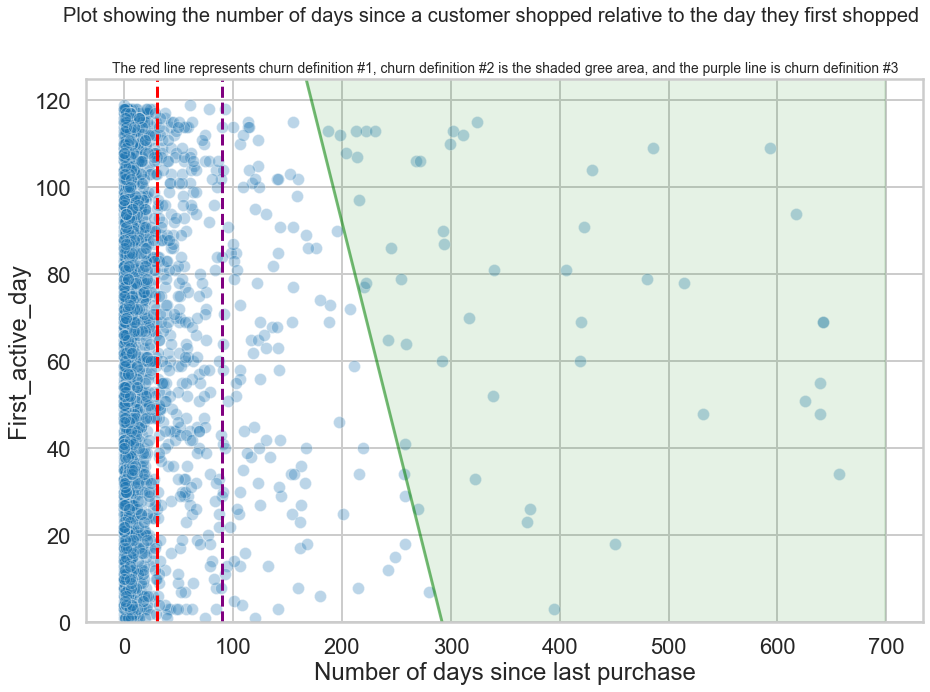

In [7]:
plt.figure(figsize=(15,10))
plt.tight_layout()
g = sns.scatterplot(x='Recency', y='First_active_day', data=df[df['First_active_day'] < 125], alpha=0.3)
# set ylimit at 125, there were five data points above this and it dramaticaly skewed the visualization of the data
ax = g.axes
ax.set_ylim(0,125)
# Creating a line to mark those customers who haven't visited in 30 days
_1 = plt.axvline(x=30, linestyle='--', color='red')
# creating a line to mark those customers who will be churned under condition #2
x = np.arange(0, 700, 1)
_2B = plt.plot(x, ((-1*x)+292), alpha = 0.5, color='g')
y = []
for item in x:
    point = ((-1*item)+292)
    y.append(point)
plt.fill_between(x, y, 125, color='green', alpha=0.1)
# Creating a line to mark those customers who haven't visited in 90 days
_3 = plt.axvline(x=90, linestyle='--', color='purple')

plt.suptitle('Plot showing the number of days since a customer shopped relative to the day they first shopped', 
            size='small')
plt.title('The red line represents churn definition #1, churn definition #2 is the shaded gree area, and the purple '
          'line is churn definition #3', size='xx-small')
plt.xlabel('Number of days since last purchase');

In [8]:
x = len(df[df['Recency']>30])
y = len(df[df['Recency']>90])
z = len(df[df['Recency'] > df['First_active_day']+365])

print('Churn definition #1 will have ', str(round(x/len(df)*100, 2)) , '% of households marked as churn')
print('Churn definition #2 will have ', str(round(z/len(df)*100, 2)) ,'% of households marked as churn')
print('Churn definition #3 will have ', str(round(y/len(df)*100, 2)) ,'% of households marked as churn')

Churn definition #1 will have  18.16 % of households marked as churn
Churn definition #2 will have  0.56 % of households marked as churn
Churn definition #3 will have  6.84 % of households marked as churn


I would seem that most customers have shopped at this grocery store chain at least 1 year after their initial purchase from the store, perhaps this could be a good opportunity to examine churn since these customers clearly haven't been revived.  However addressing the cause for these customer's churn won't help the bottom line of the store since it's such a small percentage of overall households.  

What would be better is to focus on what will capture insights that will drive customers to purchase more frequently.  In order to do so I'll look at 90-day churn since these customers could conceivably return but have also purchased from another store multiple times without returning to the grocery store being examined.  

In [9]:
df['churn'] = 0
df['churn'][df['Recency'] > 90] = 1
np.mean(df['churn'])*100

6.84

### Examining Churn Statistics

Next I'll need to take a look at the descriptive statistics for each group and identify if anything stands out between the groups. 

In [10]:
# Dropping all categorical features since we only have that data for 670 households, and dropping Recency since 
# that is what determines churn
groupby = df.drop('Recency', axis=1).select_dtypes(np.number).groupby('churn').mean()
groupby

,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,CouponRedeemed_Count,CouponSent_Count,Percent_CouponsRedeemed,TypeA,TypeB,TypeC,PercentTypeA,PercentTypeB,PercentTypeC,Count_products,Count_depts,Count_sub_cagtegory,Most_freq_product,Least_freq_product,High_volume_product,PercentPrivate,%_products_preferred_dept,%_purchases_product_displayed,%_purchases_product_mailer,%_baskets_product_mailer,%_baskets_product_displayed,Avg_quantity_purchased,Avg_basket_sales_value,Max_basket_sales_value,Min_basket_sales_value,Total_num_baskets,Avg_num_items,Max_num_items,Min_num_items,Avg_manu_disc,Max_manu_disc,Avg_coupon_disc,Max_coupon_disc,Avg_loyalty_disc,Min_loyal_disc,Max_loyal_disc,Num_stores_visited,Most_freq_store,Most_freq_time,First_active_day,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.378274,3.039931,0.069925,0.990125,332.045513,0.001830,1.671533,1.124088,0.244311,0.429349,0.196291,0.037734,587.179906,13.262774,256.298841,1.157894e+06,4.351873e+06,4.492330e+06,0.289519,0.630920,0.107045,0.162645,0.162645,0.107045,93.198532,31.806759,144.746243,1.284672,116.115500,736.206177,8556.295835,1.164878,0.027574,0.743637,0.149476,3.771812,5.728885,0.032958,35.083074,5.619579,2743.080721,1585.910262,66.021898,0.163313,3392.909708,1.950512,13.336176
1,0.046784,0.748538,0.005556,0.070175,97.251462,0.000078,0.502924,0.216374,0.029240,0.177026,0.046658,0.004386,198.403509,9.000000,110.888889,1.193303e+06,3.413839e+06,4.172396e+06,0.284028,0.634334,0.108601,0.155727,0.155727,0.108601,76.802085,29.087433,94.818713,4.596491,35.385965,597.292341,4859.204678,2.157895,0.010438,0.203918,0.080305,1.246023,5.494072,0.277953,22.969532,3.356725,2438.157895,1594.286550,64.842105,0.049769,908.633743,1.545025,38.943621


In [11]:
series = pd.Series(index=groupby.columns)
for item in series.index:
    
    pct_diff = np.abs(100 - (groupby.loc[1, item] / groupby.loc[0, item] *100))
    series[item] = pct_diff

In [12]:
series.sort_values(ascending=False)

Min_loyal_disc                   743.346849
Min_basket_sales_value           257.795056
Avg_shopping_lag                 192.014897
Percent_CouponsRedeemed           95.740150
CouponRedeemed_Count              92.912463
Percent_CampaignRedeemed          92.054979
PercentTypeC                      88.376695
TypeC                             88.031737
CampaignsRedeemed                 87.632342
Min_num_items                     85.246474
TypeB                             80.751120
PercentTypeB                      76.230065
CampaignsSent                     75.376483
Monetary                          73.219631
Max_manu_disc                     72.578261
CouponSent_Count                  70.711406
TypeA                             69.912408
Frequency                         69.525201
Total_num_baskets                 69.525201
Max_coupon_disc                   66.964859
Count_products                    66.210780
Avg_manu_disc                     62.146954
PercentTypeA                    

Here we can see those features which exhibit the strongest difference between the churned and not-churned classes.  Anything over 100 is a feature where the value is larger for churned classes than non-churned, anything less than 100 is where the values for the non-churned class is larger.  The smaller the value the closer the two classes are. 

### Preparing the data set for modelling

Creating a train/test split and scaling the data. I'm going to eliminate the categorical data since I have demographic information for less than 50% of the data set.

In [13]:
data = df.drop('Recency', axis=1).select_dtypes(np.number)
cols = data.columns
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns = cols)
X = data.drop('churn', axis=1)
y = data['churn']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Checking how well a dummy classifier does

Next, I want to see how well a dummy classifier performs before I start working with other models.  If I find that there is marginal improvement over a dummy classifier I'll know that I need to take some steps to handle the imbalance between classes. 

In [15]:
dummy = DummyClassifier(random_state=42)
dummy.fit(x_train, y_train)
dpred = dummy.predict(x_test)

print(classification_report(y_test, dpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       458
           1       0.00      0.00      0.00        42

    accuracy                           0.92       500
   macro avg       0.46      0.50      0.48       500
weighted avg       0.84      0.92      0.88       500



Here, as expected, the dummy classifier predicted all households to be not churned, and thuse had a great accuracy score but predicted none of the churned housholds correctly.   We'll be looking to see precision and recall scores improve. 

### Examining results with a LinearSVC model. 

In [16]:
linear = LinearSVC(random_state=42)
linear.fit(x_train, y_train)
lpred = linear.predict(x_test)

print(classification_report(y_test, lpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       458
           1       0.00      0.00      0.00        42

    accuracy                           0.91       500
   macro avg       0.46      0.50      0.48       500
weighted avg       0.84      0.91      0.87       500



This is still not predicting the churned households at all. 

### Examining results with KNN model.

In [17]:
knn = KNeighborsClassifier(weights = 'distance')
knn.fit(x_train, y_train)
kpred = knn.predict(x_test)

print(classification_report(y_test, kpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       458
           1       0.00      0.00      0.00        42

    accuracy                           0.91       500
   macro avg       0.46      0.50      0.48       500
weighted avg       0.84      0.91      0.87       500



This is actively worse than a dummy classifier and won't be used at all.

### Examining the results of an SVC model

In [18]:
svc = SVC(random_state=42)
svc.fit(x_train, y_train)
spred = svc.predict(x_test)

print(classification_report(y_test, spred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       458
           1       0.00      0.00      0.00        42

    accuracy                           0.92       500
   macro avg       0.46      0.50      0.48       500
weighted avg       0.84      0.92      0.88       500



This is a moderate improvement over the dummy classifier, however it isn't an improvement over the LinearSVC model.  In particular this model is not predicting the churn class. 

### Examining Results of a decision tree ensemble model

In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
rpred = rf.predict(x_test)

print(classification_report(y_test, rpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       458
           1       0.82      0.21      0.34        42

    accuracy                           0.93       500
   macro avg       0.88      0.60      0.65       500
weighted avg       0.92      0.93      0.91       500



In [20]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(x_train, y_train)
gpred = gb.predict(x_test)

print(classification_report(y_test, gpred, labels =[0,1]))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       458
           1       0.79      0.26      0.39        42

    accuracy                           0.93       500
   macro avg       0.86      0.63      0.68       500
weighted avg       0.92      0.93      0.92       500



WOW.  So while the other modes didn't predict ANY of the churned class, the ensemble models have predicted them, and are predicting churn with a much higher weighted accuracy of 0.92. 

However the random forest model seems to be slightly more precise, while finding less of the actual churned households. 

Since the entire point of this is to examine what is causing households to churn, I'll start by optimizing the gradient boosting model. 

In [24]:
print('\'Area Under Curve\' score for the gradient boosting model is: ', str(roc_auc_score(y_test, gpred)))

'Area Under Curve' score for the gradient boosting model is:  0.6276772717820752


In [ ]:
params = {'n_estimators':np.arange(50,10000), 'max_depth':np.arange(2,len(x_train.columns)), 
          'min_samples_split': np.arange(2,len(x_train_columns)), 'criterion':['friedman_mse', 'mse'], 
         'min_impurity_decrease':[0.0, 0.001, 0.01], 'max_features':['auto', 'sqrt', 'log2', 1]}
gb = GradientBoostingClassifier()
# Had a friend tell me that iterating 60 times is just as good as 100 over 90% of the time
gradient = HalvingRandomSearchCV(gb, params, factor=2, n_iter=60)
gradient.fit(x_train, y_train)
grade_best_score = gradient.best_score_
grade_best_params = gradient.best_params_
print('GB best score: ', grade_best_score)
print('GB best parameters: ', grade_best_params)

### Examining SHAP feature weights alongside the built in Gradient Boosting feature weights

Well clearly the gradient boosting model is the one to choose, with 100% accuracy across the board.  While this is suspiscious in that the rsults are so good right away, it will mean that any insights gained will be incredibly useful. 

Recall that these features will identify with high accuracy which households will churn for at least 90 days. 

In [26]:
gbweight = gb.feature_importances_
gbweight = pd.Series(gbweight, index = x_train.columns)
gbweight.sort_values(ascending=False).head(10)

Avg_shopping_lag             0.216570
Total_num_baskets            0.187887
Frequency                    0.139164
Monetary                     0.047628
Count_products               0.036372
Most_freq_product            0.027075
First_active_day             0.026188
%_products_preferred_dept    0.026024
Avg_quantity_purchased       0.022686
Avg_basket_sales_value       0.020510
dtype: float64

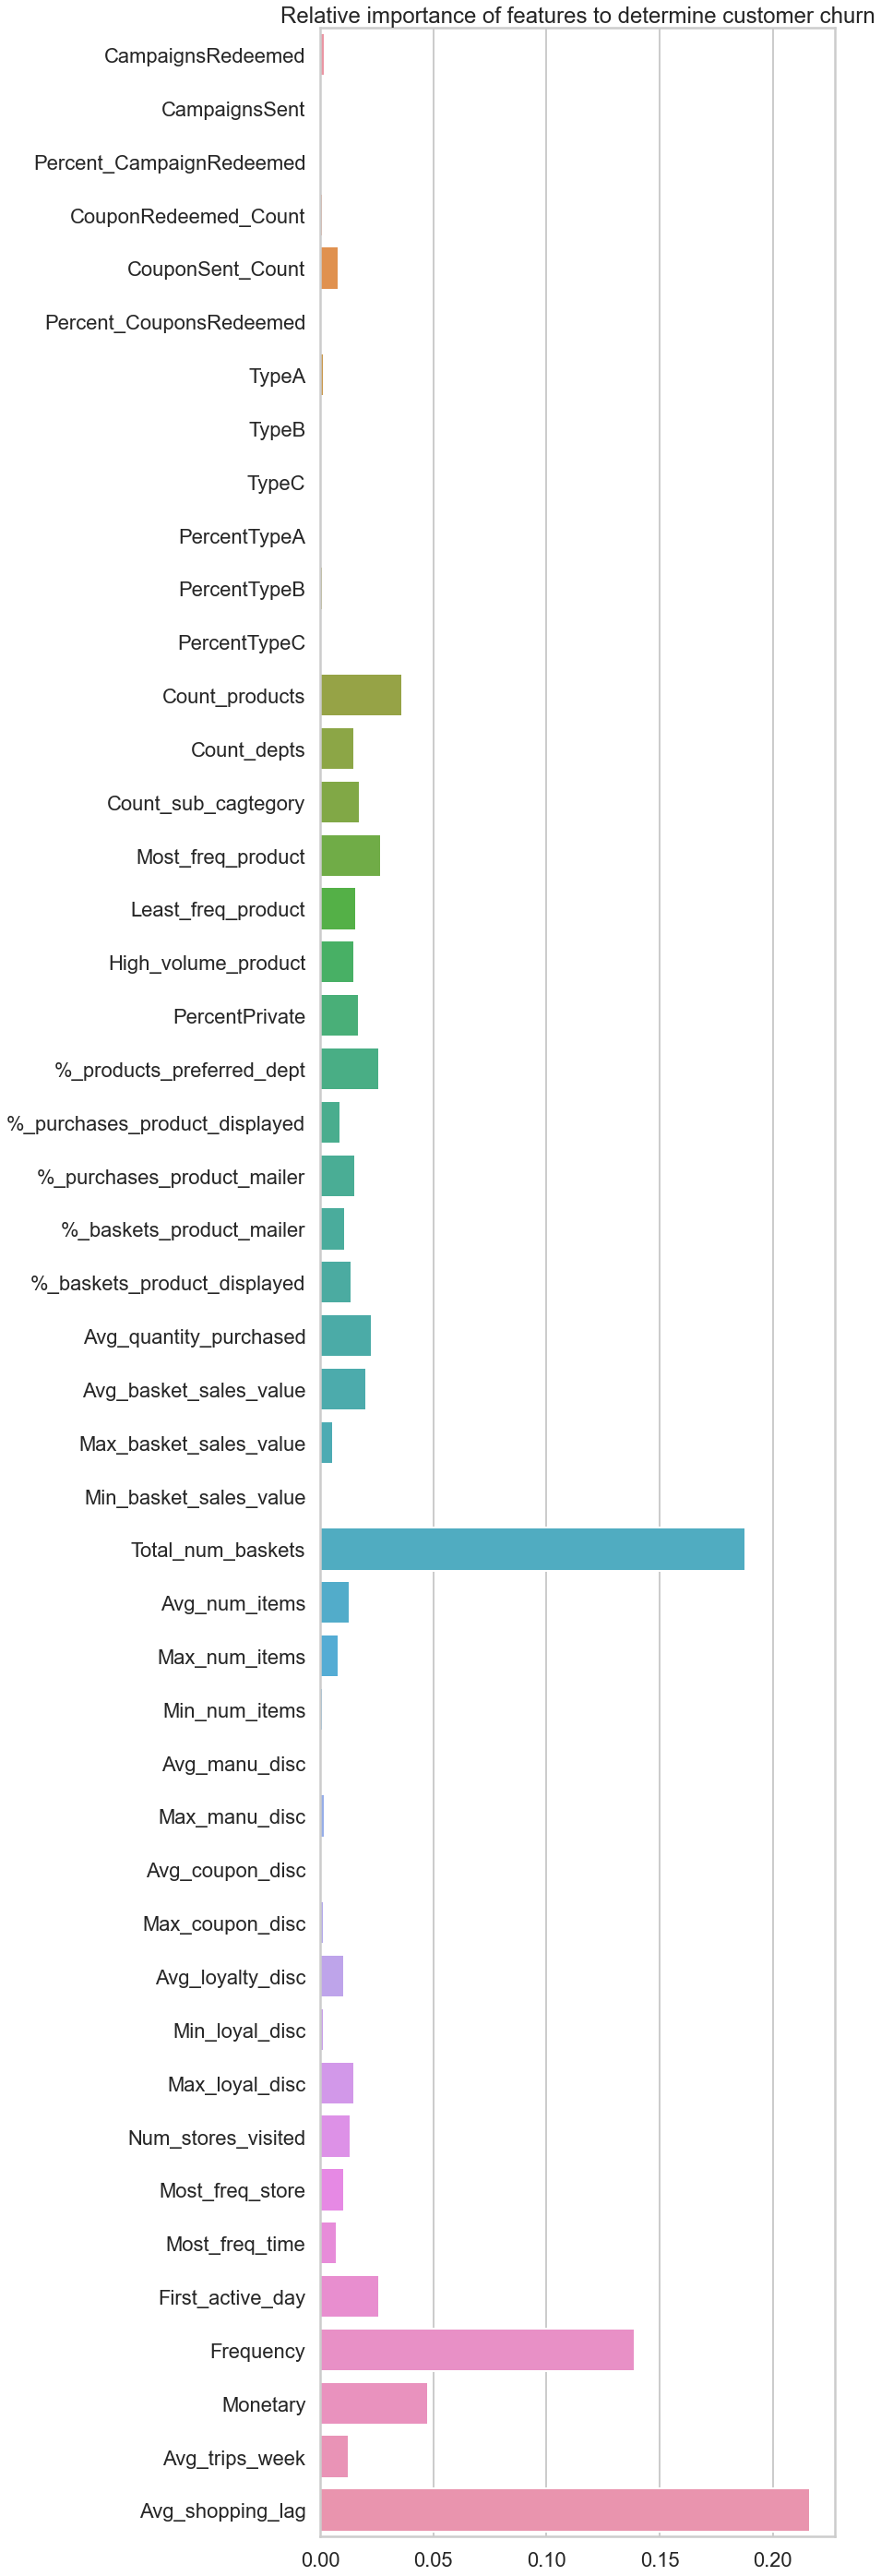

In [23]:
plt.figure(figsize=(10,50))
sns.barplot(x= gbweight, y= x_train.columns, orient='h')
plt.title('Relative importance of features to determine customer churn');